In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

In [40]:
# ! pip install sdv

In [41]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [42]:
import pandas as pd
import numpy as np

In [43]:
# read csv file as dataframe, and drop ROW_ID column
def read_csv_no_rowid(file_path):
    df = pd.read_csv(file_path)
    df.drop(["Unnamed: 0", 'row_id'], axis=1, inplace=True)

    return df

In [44]:
# check NaN value

def nan_count(df):
    print("Total columns: " + str(len(df.columns)))
    print("Total rows: " + str(len(df)))
    print("--------------")
    print(df.isnull().sum())

In [45]:
date_set_path = "../temp_sets/"

In [46]:
procedureevents_mv_sample_df = read_csv_no_rowid(date_set_path + "procedureevents_mv.csv")

In [47]:
procedureevents_mv_sample_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,value,valueuom,location,locationcategory,...,ordercategoryname,secondaryordercategoryname,ordercategorydescription,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date
0,48637,148117,244285,2133-06-08 17:44:00,2133-06-08 18:30:00,225792,46.0,min,NaN,NaN,...,Ventilation,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
1,48637,148117,244285,2133-06-08 20:00:00,2133-06-08 20:01:00,225966,1.0,None,NaN,NaN,...,Procedures,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN
2,48637,148117,244285,2133-06-08 20:00:00,2133-06-08 20:20:00,224275,20.0,min,Right Antecubital,Peripheral,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
3,48637,148117,244285,2133-06-08 20:00:00,2133-06-12 12:00:00,224277,5280.0,min,Left Antecubital,Peripheral,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
4,48637,148117,244285,2133-06-08 20:00:00,2133-06-12 21:36:00,224275,5856.0,min,NaN,NaN,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN


In [48]:
# Drop some null value
# procedureevents_mv_sample_df.dropna(subset=['hadm_id', ], inplace=True, axis=0)

In [49]:
# Drop some columns
procedureevents_mv_sample_df.drop(['location', 'locationcategory', 'storetime', 'cgid', 'secondaryordercategoryname', 
    'continueinnextdept', 'cancelreason', 'comments_editedby', 'comments_canceledby', 'comments_date'], axis=1, inplace=True)

In [50]:
nan_count(procedureevents_mv_sample_df)

Total columns: 14
Total rows: 5922
--------------
subject_id                  0
hadm_id                     0
icustay_id                  0
starttime                   0
endtime                     0
itemid                      0
value                       0
valueuom                    0
orderid                     0
linkorderid                 0
ordercategoryname           0
ordercategorydescription    0
isopenbag                   0
statusdescription           0
dtype: int64


In [51]:
# Deal with null values
# procedureevents_mv_sample_df['value'].fillna(value=0, inplace=True)

In [52]:
procedureevents_mv_sample_df.dtypes

subject_id                    int64
hadm_id                       int64
icustay_id                    int64
starttime                    object
endtime                      object
itemid                        int64
value                       float64
valueuom                     object
orderid                       int64
linkorderid                   int64
ordercategoryname            object
ordercategorydescription     object
isopenbag                     int64
statusdescription            object
dtype: object

In [53]:
# procedureevents_mv_sample_df['subject_id'] = procedureevents_mv_sample_df['subject_id'].astype(str)
# procedureevents_mv_sample_df['hadm_id'] = procedureevents_mv_sample_df['hadm_id'].astype(str)
# procedureevents_mv_sample_df['icustay_id'] = procedureevents_mv_sample_df['icustay_id'].astype(str)

# procedureevents_mv_sample_df['itemid'] = procedureevents_mv_sample_df['itemid'].astype(str)
# procedureevents_mv_sample_df['orderid'] = procedureevents_mv_sample_df['orderid'].astype(str)
# procedureevents_mv_sample_df['linkorderid'] = procedureevents_mv_sample_df['linkorderid'].astype(str)

procedureevents_mv_sample_df['starttime'] = pd.to_datetime(procedureevents_mv_sample_df['starttime'])
procedureevents_mv_sample_df['endtime'] = pd.to_datetime(procedureevents_mv_sample_df['endtime'])

In [54]:
procedureevents_mv_sample_df.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                           int64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
dtype: object

In [55]:
invalid_index = procedureevents_mv_sample_df.loc[(procedureevents_mv_sample_df['starttime'] > procedureevents_mv_sample_df['endtime']) == True].index
procedureevents_mv_sample_df.drop(invalid_index, inplace=True, axis=0)

In [56]:
len(procedureevents_mv_sample_df)

5920

---

## Build model

In [57]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations
from sdv.constraints import Inequality

In [58]:
procedureevents_mv_sample_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'itemid',
       'value', 'valueuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'ordercategorydescription', 'isopenbag', 'statusdescription'],
      dtype='object')

In [59]:
fixed_subject_hadm_icustay_constraint = FixedCombinations(
    column_names=['subject_id', 'hadm_id', 'icustay_id']
)
fixed_itemid_value_valueuom_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valueuom']
)

fixed_itemid_orderid_linkorderid_constraint = FixedCombinations(
    column_names=['orderid', 'linkorderid', 'ordercategoryname', 'ordercategorydescription']
)

starttime_endtime_constraint = Inequality(
    low_column_name='starttime',
    high_column_name='endtime'
)

In [60]:
procedureevents_mv_constraints = [fixed_subject_hadm_icustay_constraint, fixed_itemid_value_valueuom_constraint, fixed_itemid_orderid_linkorderid_constraint, starttime_endtime_constraint]

In [61]:
model = CTGAN(
    constraints=procedureevents_mv_constraints, 
    batch_size=1000,
    generator_lr=0.001,
    discriminator_lr=0.001,
    cuda=True, 
    verbose=True, 
    epochs=210)

In [62]:
len(procedureevents_mv_sample_df)

5920

In [63]:
train_data = procedureevents_mv_sample_df.loc[0:1000, : ]
model.fit(train_data)

Epoch 1, Loss G:  3.9865,Loss D: -0.0001
Epoch 2, Loss G:  3.9657,Loss D: -0.0208
Epoch 3, Loss G:  3.9752,Loss D: -0.0735
Epoch 4, Loss G:  3.8543,Loss D: -0.0885
Epoch 5, Loss G:  3.7366,Loss D: -0.0639
Epoch 6, Loss G:  3.8244,Loss D: -0.0425
Epoch 7, Loss G:  3.8277,Loss D: -0.0846
Epoch 8, Loss G:  3.9259,Loss D: -0.1372
Epoch 9, Loss G:  3.8776,Loss D: -0.0848
Epoch 10, Loss G:  3.7265,Loss D: -0.0285
Epoch 11, Loss G:  3.6360,Loss D:  0.0327
Epoch 12, Loss G:  3.5752,Loss D:  0.0603
Epoch 13, Loss G:  3.7455,Loss D:  0.0036
Epoch 14, Loss G:  3.6552,Loss D: -0.0671
Epoch 15, Loss G:  3.7022,Loss D: -0.1491
Epoch 16, Loss G:  3.6594,Loss D: -0.2200
Epoch 17, Loss G:  3.8273,Loss D: -0.2181
Epoch 18, Loss G:  3.6950,Loss D: -0.2128
Epoch 19, Loss G:  3.6364,Loss D: -0.1772
Epoch 20, Loss G:  3.5765,Loss D: -0.0166
Epoch 21, Loss G:  3.1870,Loss D:  0.1989
Epoch 22, Loss G:  2.8981,Loss D:  0.3141
Epoch 23, Loss G:  2.9163,Loss D:  0.3626
Epoch 24, Loss G:  2.9336,Loss D:  0.2728
E

In [64]:
model.save("../procedureevents_mv_model.pkl")

In [65]:
# model = CTGAN.load(("/content/drive/MyDrive/MSc Project/procedureevents_mv_model.pkl"))

In [66]:
sample = model.sample(num_rows=1000)

Sampling rows: 100%|██████████| 1000/1000 [00:00<00:00, 9040.19it/s]


In [67]:
len(sample)

1000

In [68]:
nan_count(sample)

Total columns: 14
Total rows: 1000
--------------
subject_id                  0
hadm_id                     0
icustay_id                  0
starttime                   0
endtime                     0
itemid                      0
value                       0
valueuom                    0
orderid                     0
linkorderid                 0
ordercategoryname           0
ordercategorydescription    0
isopenbag                   0
statusdescription           0
dtype: int64


In [69]:
sample.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                           int64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
dtype: object

In [70]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.7744799188755486

In [79]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.6504305820473256

<AxesSubplot:xlabel='itemid', ylabel='value'>

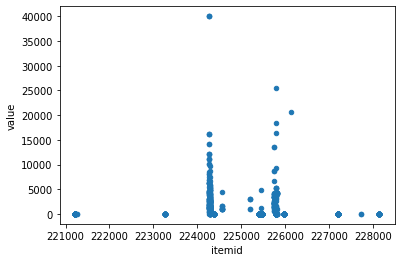

In [72]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:xlabel='itemid', ylabel='value'>

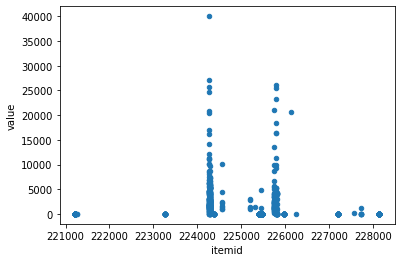

In [78]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:>

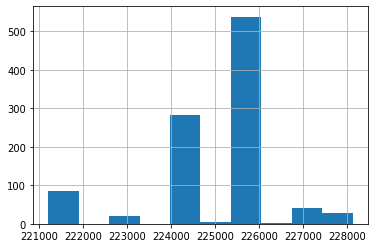

In [74]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

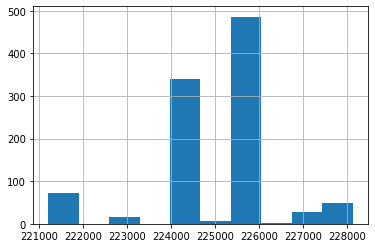

In [75]:
train_data.sort_values('itemid')['itemid'].hist()

In [76]:
# evaluate(sample, train_data, aggregate=False)